# Epitope Model Building

This notebook captures the data processing, model building, training, and initial data evaluation for an epitope discovery model. The input to the model includes site directed mutagenesis data across the length of the RBD of the SARS-CoV-2 Spike protein. The synthetic pipetides were used as the mat-alpha library in the initial experiemtn from the manuscript noted in this repository. The breadth of the mat-alpha library is exposed to another library, mat-a library, which contains peptides corresponding to different antibodies expectd to bind to the SARS-CoV-2 Spike RBD regions. Within this assay, affinity of interactions are measured by the representation of mated barcodes, the output from the AlphaSeq assay.

Here I design a model that takes as an input a two-dimensional array of the affinity measurements. The first dimension is the position across the RBD protein, while the second is the amino acid substituded in that position. A figure below gives an example heatmap of an input. For unobserved measurements, the affinity was measured to be 1 magnitude lower than the lowest estimated affinity. This modeling approach has several advantages and disadvantages, something to be said about any modeling approach. 

Some advantages of this approach:
* There would apprear to be sufficient data to estimate (within reason) a binding site from a given distribution of affinities for a given site.
* A convolutional approach would allow for neighboring sites to influence the classification of a single residue, though other models that utilize attention mechanisms (transformers) may be better at this than a convolutional approach.
* Not incorporating the region of the binding antibody (or the sequence associated with it) into the model may help to drive generalizability and let me model learn from different antibody binding what an epitope may look like. Essentially, I am not giving the model a direct way to learn sequence matching between receptor and ligand, rather behavior of ligand affinity to predict receptor binding.

Some disadvantages:
* This approach uses quite a bit of data per sample, even though there are triplicates of each mat-a antibody (CoV_binder) there are still fewer than 100 iterations within the training set. (This is managable though, but more training data is certainly something that would help improve this method).
* Across the antibodies, there is a substantial amount of redundancy in positional binding. This is observed in the PDB files for each of the 19 antibodies that were used for train / test / validation. There are essentially three core binding regions. There is a risk that the model can learn these positional behaviors from the data and then just always predict these regions in the output, but the risk can be managed through model development and training approaches. 

The model selected for this classification take on a classic U-net architecture, using convolutional and pooling steps to encode a great number of features describing regions of the input data while shrinking its resolution. The modeling approach then decodes these features and incorporates the equivalent level's data through a skip connection, leading to very refined boundries between classified regions. When diagrammed, the graphic often looks like the letter "U", hence the naming. This type of model is often used to train semantic segmentation algorithms, which can be quite powerful at detecting boundries between different objects. In this case, given the affinity data, where is there a potential protein-protien interaction between the targets.

A note about the training information gathered from the PDB files. It is likely that the PDB files do not completely represent functional binding regions for the antibodies, as approaches to crystalize these compounds together often push into non-physiological conditions, or conditions that may not be representative during infection. This suggests a level of expected discordance between the AlphaSeq data and the PDB data. Yet we will need to use the PDB data for verifying correct classification of the AlphaSeq data by the model, so during the training process the model should be expected to be biased to PDB binding regions as well as aim to be as unbiased as it can be by using the AlphaSeq data to predict. Essentially a bit of a struggle that the training will be sorting out. This is likely influence the final performance metric though, and it should be expected that the Jaccard Index, measuring the degree of similarity between the regions of antibody binding from PDB files and the regions predicted by the model, will be quite low. Still, increases in this performance metric can indicate a higher agreement between datasets.

## Dependencies

In [1]:
import pandas as pd
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

2024-12-08 12:37:36.168074: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-08 12:37:36.168132: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-08 12:37:36.168144: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-08 12:37:36.175969: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Data Pre-Processing
Comments included in code block below, but generally this group of blocks is aimed at pre-processing the raw AlphaSeq data into the format needed for model training. This will include operations such as:
* Filtering for mata and matalpha descriptions with the correct information to be used for training / prediction based on the SSM experiment.
* Curating / completing the data, making sure that there are no empty spaces in the data, NaN is fine but missing parts would likely lead to errors in formating.
* Filling of NaN values, set to be 1 magnitude below the lowest observed affinity (minimum affinity - 1.0).

In [2]:
# Select only mutagenesis data from experiment 1 by filtering for CoV_binder in mata_desc and the correct mutagenesis format in matalpha_desc
pdbids = pd.read_csv("./additional_data/pdb_identifiers.csv")
pdb_resid = pd.read_csv("./additional_data/interacting_residues.csv")
raw_data = pd.read_csv("./manuscript_data/supp_tbl_4-cov2_ssm_raw_data.csv")
cov_binder_data = raw_data[(raw_data["mata_description"].str.extract(pat = r"(^[\w]{10})") == "CoV_binder")[0]]
cov_binder_data = cov_binder_data[cov_binder_data["matalpha_description"].str.match(pat = r"^[\w][\d]+[\w]_[ATGC]{3}")]

# Separate the matalpha_desc to give the AA context and position, {initial AA}{position int}{mutated AA}_{codon}, i.e. P209W_TGG --> P, 209, W, TGG
cov_binder_data[["AAsub", "nts"]] = cov_binder_data["matalpha_description"].str.extract(pat = r"(^[\w][\d]+[\w])_([ATGC]{3})")
cov_binder_data[["ref", "pos", "mut"]] = cov_binder_data["AAsub"].str.extract(pat = r"(^[\w])([\d]+)([\w])")
cov_binder_data["pos"] = cov_binder_data["pos"].astype(int) + 318 # Mutagenesis position offset from reference sequence
cov_binder_data = cov_binder_data.sort_values(by = ["mata_description", "pos", "mut"]).reset_index(drop = True)

# Create a combined sample name with the mata_desc
cov_binder_data["mata_name"] = cov_binder_data["mata_description"] + "_" +cov_binder_data["sample_name"].astype(str)

# Select columns for analysis and include anything that maybe missing in the data (pred_aff = NaN for missing values)
## Create unique lists of all dimensions
mata_name_list = sorted(cov_binder_data["mata_name"].unique())
pos_list = sorted(cov_binder_data["pos"].unique())
mut_list = sorted(cov_binder_data["mut"].unique())
## Select and set as catagorical
cov_binder_data = cov_binder_data[["mata_name", "mut", "pos", "pred_aff"]]
cov_binder_data["mata_name"] = pd.Categorical(cov_binder_data["mata_name"], ordered = True, categories = mata_name_list)
cov_binder_data["pos"] = pd.Categorical(cov_binder_data["pos"], ordered = True, categories = pos_list)
cov_binder_data["mut"] = pd.Categorical(cov_binder_data["mut"], ordered = True, categories = mut_list)
## Complete data for all catagories
cov_binder_data = cov_binder_data.set_index(["mata_name", "pos", "mut"]).unstack().stack(dropna = False).reset_index()

# Convert unobserved affinities to one order of magnitude below the lowest observed affinity.
cov_binder_data["pred_aff"] = cov_binder_data["pred_aff"].fillna(cov_binder_data["pred_aff"].min() - 1.0)

# Remake the CoV_binder identifier to use for dataset grouping
cov_binder_data["Short_Name"] = cov_binder_data["mata_name"].str.extract(pat = r"(CoV_binder_[\d]+)")

# Long format for completed mutagenesis dataset
cov_binder_data

/tmp/ipykernel_1001532/2132351138.py:28: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  cov_binder_data = cov_binder_data.set_index(["mata_name", "pos", "mut"]).unstack().stack(dropna = False).reset_index()


,mata_name,pos,mut,pred_aff,Short_Name
0,CoV_binder_10_HL_1,319,A,0.898197,CoV_binder_10
1,CoV_binder_10_HL_1,319,D,-2.117423,CoV_binder_10
2,CoV_binder_10_HL_1,319,E,-2.117423,CoV_binder_10
3,CoV_binder_10_HL_1,319,F,0.747161,CoV_binder_10
4,CoV_binder_10_HL_1,319,G,-2.117423,CoV_binder_10
...,...,...,...,...,...
554890,CoV_binder_9_LH_3,527,S,-2.117423,CoV_binder_9
554891,CoV_binder_9_LH_3,527,T,0.863659,CoV_binder_9
554892,CoV_binder_9_LH_3,527,V,-2.117423,CoV_binder_9
554893,CoV_binder_9_LH_3,527,W,-0.123413,CoV_binder_9


Notes: Certain structures are not in the correct range, and will need to be corrected for the modeling process. Structures that need investigating are as follows:
* CR3014-D1,CoV_binder_15,8WFH --> offset 332 (1 --> 333) (Need to correct when creating Y)
* FC05,CoV_binder_19,7D4G --> Not RBD region of the protein
* VHH-55,CoV_binder_33,6WAR --> Different protein (MERS)

To rectify this, the two structures used above that are not the RBD region of the SARS-CoV-2 Spike protein will be moved to the discovery set. The other (CR3014-D1) will need to be offset when developing the Y data from the structures.

In [3]:
# Separate out discovery cohort of data (data where PDB info was not available for verification of binding sites)
## Non-conventional binders below do not indicate binding from the structure in the RBD, this may be due to the struction not containing the RBD, the annotations in the PDB are
## different than the other crystals, or the structure was developed with a different Corona spike protein (MERS for example).
non_conventional_binders = ["CoV_binder_19", "CoV_binder_33"]
discovery_data_1 = cov_binder_data[~cov_binder_data["Short_Name"].isin(pdbids["Short_Name"].unique())]
discovery_data_2 = cov_binder_data[cov_binder_data["Short_Name"].isin(non_conventional_binders)]
pre_X_discov = pd.concat([discovery_data_1, discovery_data_2], axis = 0, ignore_index = True)

# Other splits of the data should be separated by CoV binder, yet since there are repeats, I'll use a manual process to separate the groups and then format the data.
# Aim for a 80/10/10 split, where 80% is used for training, 10% is used for testing, and 10% is used for validation at the end (this will be used to compare against current algorithm)
# Yet I only have 19 different PDB files to support, and I feel that there should be  a minimum of 3 in test and val sets each, leaving 13 for training. 
# So the split is more like 68/16/16% (13/3/3).
# random.seed(0)
train_list, init_test_list = train_test_split(list(pdbids["Short_Name"][~pdbids["Short_Name"].isin(non_conventional_binders)]), test_size = 6/19, random_state = 0)
test_list, val_list = train_test_split(list(init_test_list), test_size = 0.5, random_state = 0)
print(f"Training: {sorted(train_list)}.")
print(f"Test: {sorted(test_list)}.")
print(f"Validation: {sorted(val_list)}.")

Training: ['CoV_binder_1', 'CoV_binder_11', 'CoV_binder_14', 'CoV_binder_15', 'CoV_binder_16', 'CoV_binder_24', 'CoV_binder_29', 'CoV_binder_3', 'CoV_binder_4', 'CoV_binder_6', 'CoV_binder_7', 'CoV_binder_8', 'CoV_binder_9'].
Test: ['CoV_binder_12', 'CoV_binder_20', 'CoV_binder_30'].
Validation: ['CoV_binder_10', 'CoV_binder_2', 'CoV_binder_28'].


## Format the data for training and evaluation
1) The data will be separated into the train, test, and val datasets by selecting which samples go in which. Each dataset is in a long format.
2) The datasets will be formated to numpy arrays in the correct configuration and will be indexed with related PDB information (also in a numpy array).
3) The numpy arrays will be converted to tensors and will be ready for model training.

In [4]:
# Structure the X data for each data set
pre_X_train = cov_binder_data.loc[cov_binder_data["Short_Name"].isin(train_list)]
pre_X_test = cov_binder_data.loc[cov_binder_data["Short_Name"].isin(test_list)]
pre_X_val = cov_binder_data.loc[cov_binder_data["Short_Name"].isin(val_list)]

# Normalize / Scale all data to training data (Z-standard)
train_mean = np.mean(pre_X_train["pred_aff"])
train_std = np.std(pre_X_train["pred_aff"])

pre_X_train["pred_aff"] = (pre_X_train["pred_aff"] - train_mean) / train_std
pre_X_test["pred_aff"] = (pre_X_test["pred_aff"] - train_mean) / train_std
pre_X_val["pred_aff"] = (pre_X_val["pred_aff"] - train_mean) / train_std
pre_X_discov["pred_aff"] = (pre_X_discov["pred_aff"] - train_mean) / train_std

/tmp/ipykernel_1001532/3901482852.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_X_train["pred_aff"] = (pre_X_train["pred_aff"] - train_mean) / train_std
/tmp/ipykernel_1001532/3901482852.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pre_X_test["pred_aff"] = (pre_X_test["pred_aff"] - train_mean) / train_std
/tmp/ipykernel_1001532/3901482852.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

### Function to format the model data and output tensors for training / prediction

In [5]:
def format_model_data(pre_X, pdb_resid, pos_list, include_Y = True, pad_to = 168):
    """
    Given an input pre_X_* dataframe, output X_* data in the format for tensorflow model training.
    Also generate corresponding Y_* data in the appropriate format, if Y_* data is available.

    Args:
        pre_X: pandas dataframe in long format (completed) for samples.
        pdb_resid: pandas dataframe with pdb interacting data at the residual level.
        include_Y: bool indicating if corresponding Y data should be generated. Default True, set to False for discovery dataset.
        pad_to: int indicating the array length desired, if array positional length doesn't match, then minimal values from 
            the array will be used to pad the end of the arrays. Needed for UNet model downstream.

    Returns:
        index, X_* and Y_* formated arrays for use in training and predicting, Y_* only output if 'include_Y' is set to True. 
        The index is a list of mata_name included in the pre_X dataframe.
    """
    # Create a list of each "sample" from the input pre_X object
    pre_X_list = [pre_X[pre_X["mata_name"] == x] for x in pre_X["mata_name"].unique()]
    
    # Initialize returned objects
    index_list = []
    X_list = []
    if include_Y:
        Y_list = []

    # Loop over pre_X_list and append data
    for df in pre_X_list:
        
        # Get mata_name and short_name
        mata_name = df["mata_name"].unique()[0]
        short_name = df["Short_Name"].unique()[0]
        
        # Append mata_name to index list
        index_list.append(mata_name)

        # Shape array for X
        df = df.drop(["mata_name", "Short_Name"], axis = 1)
        df = df.sort_values(by = ["pos", "mut"]).reset_index(drop = True)
        df_2D = df.pivot(index = ["pos"], columns = "mut", values = "pred_aff").to_numpy()

        # Pad if needed
        if df_2D.shape[0] < pad_to:
            pad_array = np.ones((pad_to - df_2D.shape[0], df_2D.shape[1]))
            df_2D = np.concatenate([df_2D, df_2D.min() * pad_array], axis = 0)
        
        # Append to X_list
        X_list.append(df_2D)

        if include_Y:
            # Gather Y data
            y_df = pdb_resid[pdb_resid["Short_Name"] == short_name]
            y_bind_pos = list(set(y_df["residnum"].astype(int)))
            if short_name == "CoV_binder_15":
                y_bind_pos = [x + 332 for x in y_bind_pos]
            y_bind_array = np.array((), dtype = int)
            
            # Loop through positions in order to see if they bind
            for pos in pos_list:
                if pos in y_bind_pos:
                    y_bind_array = np.append(y_bind_array, 1)
                else:
                    y_bind_array = np.append(y_bind_array, 0)
            
            # Pad if needed
            if y_bind_array.shape[0] < pad_to:
                pad_array = np.zeros((pad_to - y_bind_array.shape[0]))
                y_bind_array = np.append(y_bind_array, pad_array)

            # Append to Y_list
            Y_list.append(y_bind_array)

    if include_Y:
        Y_list = np.array(Y_list)
        Y_list = Y_list.reshape(Y_list.shape[0], Y_list.shape[1], 1)
        Y_tensor = tf.convert_to_tensor(Y_list, dtype = tf.float32)
        return index_list, tf.convert_to_tensor(np.array(X_list), dtype = tf.float32), Y_tensor
    else:
        return index_list, tf.convert_to_tensor(np.array(X_list), dtype = tf.float32)

### Construct the different datasets between train / test / validation and lastly discovery

In [6]:
index_train, X_train, Y_train = format_model_data(pre_X_train, pdb_resid, pos_list, include_Y = True)
index_test, X_test, Y_test = format_model_data(pre_X_test, pdb_resid, pos_list, include_Y = True)
index_val, X_val, Y_val = format_model_data(pre_X_val, pdb_resid, pos_list, include_Y = True)
index_discov, X_discov = format_model_data(pre_X_discov, pdb_resid, pos_list, include_Y = False)

# Build UNet Model
The following code block contains two operations used in the UNet model, the encoder and decoder blocks. The encoder will output two objects, one after pooling and the other just before pooling. This builds in the option to use skip connections in the model architectures (of which 3 are included below).

Three UNet models are set up below (or functions that will generate the models). `unet*_model` will generate a UNet model of different level depth. Level 1 means there is only one step down to a smaller spatial size before coming back "up the U". Level 2 has two steps and Level 3 has three steps. With each increase in steps, there is a significant increase in the number of parameters to train. The final model selected here has 4.4M parameters, but can be trained in a matter of 2-5 minutes depending on the number of epochs used.

In [7]:
def encoder_block(inputs = None, n_filters = 16, kernel_size = 3, strides = 1, dropout_prob = 0.0, max_pooling = True, pool_size = 2):
    """
    Convolutional (1D) downsampling block, used for the downward slope of the UNet,
    each convolutional step will reduce the "length" of the input, while the filters,
    will increase the depth. This approach uses two consecutive convolutional steps, 
    identical parameters.

    Args:
        inputs: Input tensor.
        n_filters: int number of filters to use for convolutions.
        kernel_size: int size of the filter to use, single dimension.
        strides: int size of step to take for convolutions.
        dropout_prob: float indicating the dropout probability to use during training.
        max_pooling: bool indicating if max pooling should be used during the spatial dimension reduction.
        pool_size: int indicating the size of the max pooling operation.
    
    Returns:
        next_layer, skip_connection: Next layer inputs and skip connection object.
    """
    # Initial Convolutional step (1D)
    conv1d = tf.keras.layers.Conv1D(
            filters = n_filters,
            kernel_size = kernel_size,
            strides = strides,
            activation = "relu",
            padding = "same",
            kernel_initializer = "he_normal"
        )(inputs)
    
    # Seconda convolutional step (1D)
    conv1d = tf.keras.layers.Conv1D(
            filters = n_filters,
            kernel_size = kernel_size,
            strides = strides,
            activation = "relu",
            padding = "same",
            kernel_initializer = "he_normal"
        )(conv1d)
    
    # If dropout is used during training, add a dropout step.
    if dropout_prob > 0:
        conv1d = tf.keras.layers.Dropout(dropout_prob)(conv1d)

    # If max pooling is used, add the max pooling step.
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling1D(pool_size = pool_size)(conv1d)
    else:
        next_layer = conv1d

    skip_connection = conv1d

    return next_layer, skip_connection

def decoder_block(expansive_input, contractive_input, n_filters = 16, kernel_size = 3):
    """
    Convolutional (1D) upsampling or decoder. The idea is that the model is moving from
    depth to length again, refining the resolution for final classification.

    Arguments:
        expansive_input: input from previous layer of the UNet.
        contractive_input: input from the equivalent level skip layer.
        n_filters: int indicating the number of filters to use for convolutions.
        kernel_size: int indicating the size of filters to use.
    
    Returns:
        conv1d: Tensor output.
    """
    # Transpose convolutional layer using the previous layers output.
    up_step = tf.keras.layers.Conv1DTranspose(
            filters = n_filters,
            kernel_size = kernel_size,
            strides = 2,
            padding = "same"        
        )(expansive_input)
    
    # Merge with the skip connection layer
    merge = tf.keras.layers.concatenate([up_step, contractive_input], axis = 2)
    
    # First convolution step
    conv1d = tf.keras.layers.Conv1D(
            filters = n_filters,
            kernel_size = kernel_size,
            activation = "relu",
            padding = "same",
            kernel_initializer = "he_normal"
        )(merge)
    
    # Second convolutional step
    conv1d = tf.keras.layers.Conv1D(
            filters = n_filters,
            kernel_size = kernel_size,
            activation = "relu",
            padding = "same",
            kernel_initializer = "he_normal"
        )(conv1d)
    
    return conv1d

def unet1_model(input_size = (168, 19), n_filters = 16, kernel_size = 3, n_classes = 1):
    """
    UNet model architecture. Initial encoder blocks will be used to "contract" the input, while
    using different "filters" to capture aspects in the convolutions. At the bottom of the U, 
    the data will take a turn upward and start being decoded. These steps will include the 
    equivalent level encoder output, prior to max pooling. This helps with resolving boundries
    between the final classes. The number of classes that we are looking at in this problem is
    only 1 (bound and unbound).

    Arguments:
        input_size: expected size of the input tensors.
        n_filters: int giving the bases count for filters used in the modeling.
        n_classes: int indicating the number of classes expected in the output.
    
    Returns:
        model: tf.keras.model object.
    """
    inputs = tf.keras.layers.Input(input_size)
    
    # Encoding steps, three steps will be used initially.
    enc_block_1 = encoder_block(inputs, n_filters = n_filters * 2**0, kernel_size = kernel_size)
    enc_block_2 = encoder_block(enc_block_1[0], n_filters = n_filters * 2**1, kernel_size = kernel_size, dropout_prob = 0.1, max_pooling = False)

    # Decoding steps
    dec_block_3 = decoder_block(enc_block_2[0], enc_block_1[1], n_filters = n_filters * 2**1, kernel_size = kernel_size)

    # Final steps of model
    cla_block_4 = tf.keras.layers.Conv1D(
            filters = n_filters,
            kernel_size = kernel_size,
            activation = "relu",
            padding = "same",
            kernel_initializer = "he_normal"
        )(dec_block_3)
    
    cla_block_5 = tf.keras.layers.Conv1D(filters = n_classes, kernel_size = 1, padding = "same")(cla_block_4)

    model = tf.keras.Model(inputs = inputs, outputs = cla_block_5)

    return model


def unet2_model(input_size = (168, 19), n_filters = 16, kernel_size = 3, n_classes = 1):
    """
    UNet model architecture. Initial encoder blocks will be used to "contract" the input, while
    using different "filters" to capture aspects in the convolutions. At the bottom of the U, 
    the data will take a turn upward and start being decoded. These steps will include the 
    equivalent level encoder output, prior to max pooling. This helps with resolving boundries
    between the final classes. The number of classes that we are looking at in this problem is
    only 1 (bound and unbound).

    Arguments:
        input_size: expected size of the input tensors.
        n_filters: int giving the bases count for filters used in the modeling.
        n_classes: int indicating the number of classes expected in the output.
    
    Returns:
        model: tf.keras.model object.
    """
    inputs = tf.keras.layers.Input(input_size)
    
    # Encoding steps, three steps will be used initially.
    enc_block_1 = encoder_block(inputs, n_filters = n_filters * 2**0, kernel_size = kernel_size)
    enc_block_2 = encoder_block(enc_block_1[0], n_filters = n_filters * 2**1, kernel_size = kernel_size)
    enc_block_3 = encoder_block(enc_block_2[0], n_filters = n_filters * 2**2, kernel_size = kernel_size, dropout_prob = 0.3, max_pooling = False)

    # Decoding steps
    dec_block_4 = decoder_block(enc_block_3[0], enc_block_2[1], n_filters = n_filters * 2**1, kernel_size = kernel_size)
    dec_block_5 = decoder_block(dec_block_4, enc_block_1[1], n_filters = n_filters * 2**0, kernel_size = kernel_size)

    # Final steps of model
    cla_block_6 = tf.keras.layers.Conv1D(
            filters = n_filters,
            kernel_size = kernel_size,
            activation = "relu",
            padding = "same",
            kernel_initializer = "he_normal"
        )(dec_block_5)
    
    cla_block_7 = tf.keras.layers.Conv1D(filters = n_classes, kernel_size = 1, padding = "same")(cla_block_6)

    model = tf.keras.Model(inputs = inputs, outputs = cla_block_7)

    return model


def unet3_model(input_size = (168, 19), n_filters = 16, kernel_size = 3, n_classes = 1):
    """
    UNet model architecture. Initial encoder blocks will be used to "contract" the input, while
    using different "filters" to capture aspects in the convolutions. At the bottom of the U, 
    the data will take a turn upward and start being decoded. These steps will include the 
    equivalent level encoder output, prior to max pooling. This helps with resolving boundries
    between the final classes. The number of classes that we are looking at in this problem is
    only 1 (bound and unbound).

    Arguments:
        input_size: expected size of the input tensors.
        n_filters: int giving the bases count for filters used in the modeling.
        n_classes: int indicating the number of classes expected in the output.
    
    Returns:
        model: tf.keras.model object.
    """
    inputs = tf.keras.layers.Input(input_size)
    
    # Encoding steps, three steps will be used initially.
    enc_block_1 = encoder_block(inputs, n_filters = n_filters * 2**0, kernel_size = kernel_size)
    enc_block_2 = encoder_block(enc_block_1[0], n_filters = n_filters * 2**1, kernel_size = kernel_size)
    enc_block_3 = encoder_block(enc_block_2[0], n_filters = n_filters * 2**2, kernel_size = kernel_size)
    enc_block_4 = encoder_block(enc_block_3[0], n_filters = n_filters * 2**3, kernel_size = kernel_size, dropout_prob = 0.3, max_pooling = False)

    # Decoding steps
    dec_block_5 = decoder_block(enc_block_4[0], enc_block_3[1], n_filters = n_filters * 2**2, kernel_size = kernel_size)
    dec_block_6 = decoder_block(dec_block_5, enc_block_2[1], n_filters = n_filters * 2**1, kernel_size = kernel_size)
    dec_block_7 = decoder_block(dec_block_6, enc_block_1[1], n_filters = n_filters * 2**0, kernel_size = kernel_size)

    # Final steps of model
    cla_block_8 = tf.keras.layers.Conv1D(
            filters = n_filters,
            kernel_size = kernel_size,
            activation = "relu",
            padding = "same",
            kernel_initializer = "he_normal"
        )(dec_block_7)
    
    cla_block_9 = tf.keras.layers.Conv1D(filters = n_classes, kernel_size = 1, padding = "same")(cla_block_8)

    model = tf.keras.Model(inputs = inputs, outputs = cla_block_9)

    return model


def plot_history(model_hist):
    """
    Plot the captured metrics during training for the different datasets.

    Arguments:
        model_hist: model_history object produced during fit.
    
    Returns:
        plot of the metrics across epochs.
    """
    df = pd.DataFrame(model_hist.history).reset_index()
    df = df.melt(id_vars="index")
    p1 = sns.FacetGrid(data = df, col = "variable", hue = "variable", col_wrap = 4)
    p1.map(plt.plot, "index", "value")
    return p1

## Model specification
Below is where I set a number of parameters that control the final scale of the model. A summary is printed for the saved model giving details about the shapes of tensors and the parameters used. 

In [8]:
# Model dimensions and training params
pos_dim = 168
mut_dim = 19
n_filters = 64
kernel_size = 19
learning_rate = 0.000003
epochs = 300

unet = unet2_model(input_size = (pos_dim, mut_dim), n_filters = n_filters, kernel_size = kernel_size)
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 168, 19)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 168, 64)              23168     ['input_1[0][0]']             
                                                                                                  
 conv1d_1 (Conv1D)           (None, 168, 64)              77888     ['conv1d[0][0]']              
                                                                                                  
 max_pooling1d (MaxPooling1  (None, 84, 64)               0         ['conv1d_1[0][0]']            
 D)                                                                                           

## Train UNet model
The model is first compiled and then the training history is captured in the `model_history` object. As this is really only a binary classification challenge, the binary cross entropy is used for loss measurement. A note in training, default learning rates are quite large and lead to unstable model training. The learning rate here was reduced (parameter above) to maintain stable model generation.

In [9]:
unet.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate),
    loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
    metrics = ["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [10]:
tf.random.set_seed(0)

model_history = unet.fit(
    x = X_train, 
    y = Y_train, 
    validation_data = (X_test, Y_test), 
    shuffle = True, 
    epochs = epochs
)

Epoch 1/300
3/3 [==============================] - 3s 327ms/step - loss: 1.0334 - accuracy: 0.4358 - precision: 0.1241 - recall: 0.6601 - val_loss: 0.9798 - val_accuracy: 0.5083 - val_precision: 0.1113 - val_recall: 0.5958
Epoch 2/300
3/3 [==============================] - 1s 187ms/step - loss: 0.9431 - accuracy: 0.5284 - precision: 0.1200 - recall: 0.5018 - val_loss: 0.8987 - val_accuracy: 0.5937 - val_precision: 0.1048 - val_recall: 0.4333
Epoch 3/300
3/3 [==============================] - 1s 177ms/step - loss: 0.8617 - accuracy: 0.6182 - precision: 0.1197 - recall: 0.3751 - val_loss: 0.8256 - val_accuracy: 0.6833 - val_precision: 0.0980 - val_recall: 0.2833
Epoch 4/300
3/3 [==============================] - 1s 179ms/step - loss: 0.7882 - accuracy: 0.6978 - precision: 0.1145 - recall: 0.2491 - val_loss: 0.7586 - val_accuracy: 0.7611 - val_precision: 0.0923 - val_recall: 0.1708
Epoch 5/300
3/3 [==============================] - 1s 182ms/step - loss: 0.7259 - accuracy: 0.7554 - precisi

## Model Training History
Below is a plot showing the captured metrics during training, these are evaluated at the end of each epoch. Several aspects of these data are helpful in understanding the model. To note, the precision and recall of the validation data are helpful. The interpretation of the precision is that when the model predicts the binding site, it has that chance that it matches with the PDB information (~60%). In comparison, the recall can be interpreted as the proportion of PDB binding sites correctly predicted out of all the correct PDB sites (~20%). So in the validation set, the model is predicting about 20% of the PDB regions, but is also predicting a good number of other locations for antibody binding. We can review those below.

To note as well, the accruacy and loss are relatively stable and equivalent between the training and test set, suggesting these isn't a high degree of overfitting to the training set. Yet the discordance in precision suggests that there is more bias to the training data. During model training and changing parameters, I found that the precision metric was highly sensitive to small changes in the models. This is likely due to so few residues being represented in a single sample as binding residues.

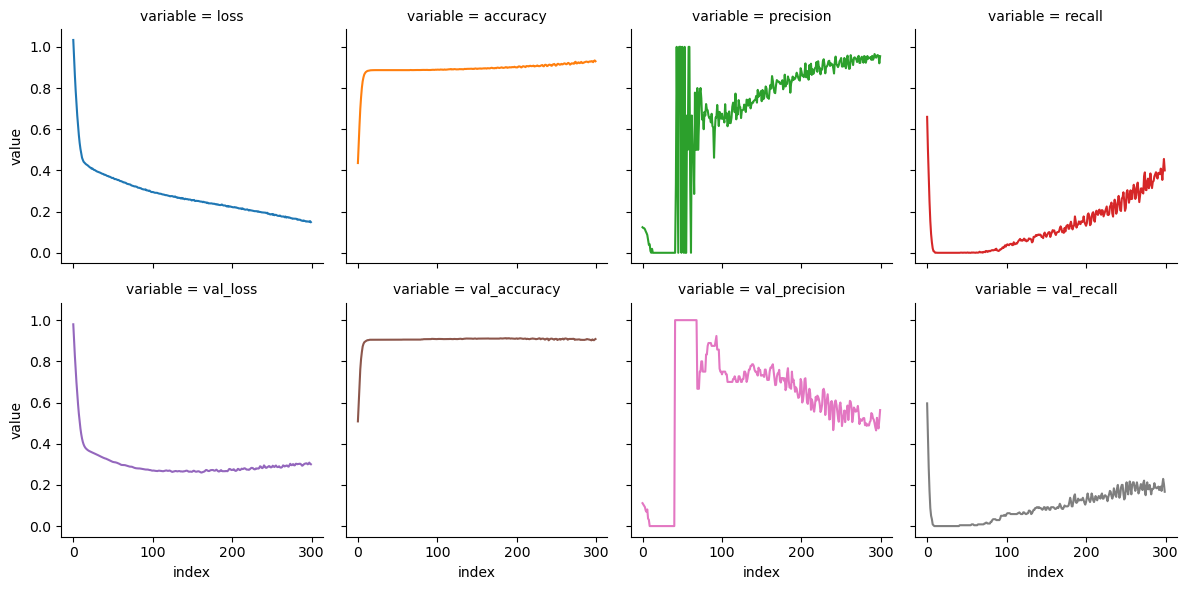

In [27]:
plot_history(model_history)

## Model archiving
This is commented out so as to not overwrite the model saved.

In [ ]:
# Save model
# unet.save("./models/unet_lvl2_epitope_discovery_4M")

INFO:tensorflow:Assets written to: ./models/unet_lvl2_epitope_discovery_4M/assets


INFO:tensorflow:Assets written to: ./models/unet_lvl2_epitope_discovery_4M/assets


# Results
Below are a series of figures, including one that shows what the training data looks like, another that shows the predictions of the model on that same data (a very high degree of concordance can be visually gathered), then figures of the test, validation, and discovery predictions.

<Axes: title={'center': 'Training Set PDB Results (Truth)'}, xlabel='Position in Spike RBD', ylabel='matA Description Index'>

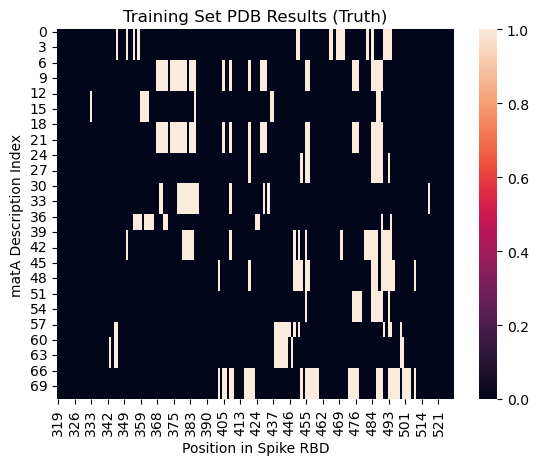

In [ ]:
# Plot showing the "truth" or Y data used for training in the training set, gathered from PDB structures.
Y_train_plt = np.array(Y_train).reshape((Y_train.shape[0], Y_train.shape[1])) > 0
Yh_train_plt_df = pd.DataFrame(Y_train_plt)
Yh_train_plt_df.columns = padded_pos_array.tolist()

training_truth_plot = sns.heatmap(data = Yh_train_plt_df)
training_truth_plot.set(xlabel = "Position in Spike RBD", ylabel = "matA Description Index", title = "Training Set PDB Results (Truth)")
training_truth_plot

3/3 [==============================] - 0s 57ms/step


<Axes: title={'center': 'Training Set Predictions'}, xlabel='Position in Spike RBD', ylabel='matA Description Index'>

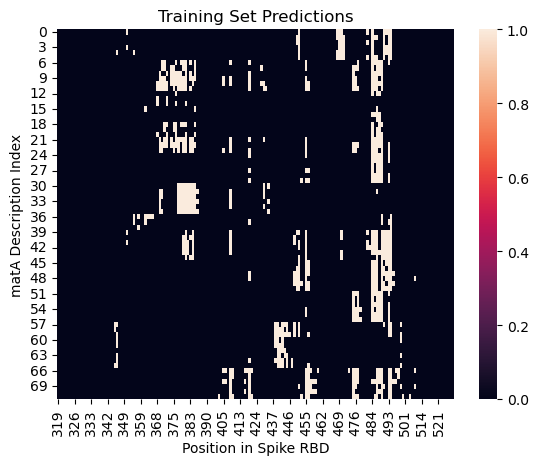

In [ ]:
# Figure showing the training set predictions, quite concordant with the above figure (expected)
padded_pos_array = np.array(pos_list)
padded_pos_array = np.append(padded_pos_array, (528,529,530))

Yh_train = unet.predict(x = X_train)
Yh_train = Yh_train.reshape((Yh_train.shape[0], Yh_train.shape[1])) > 0
Yh_train_df = pd.DataFrame(Yh_train)
Yh_train_df.columns = padded_pos_array.tolist()

training_plot = sns.heatmap(data = Yh_train_df)
training_plot.set(xlabel = "Position in Spike RBD", ylabel = "matA Description Index", title = "Training Set Predictions")
training_plot

1/1 [==============================] - 0s 50ms/step


<Axes: title={'center': 'Test Set Predictions'}, xlabel='Position in Spike RBD', ylabel='matA Description'>

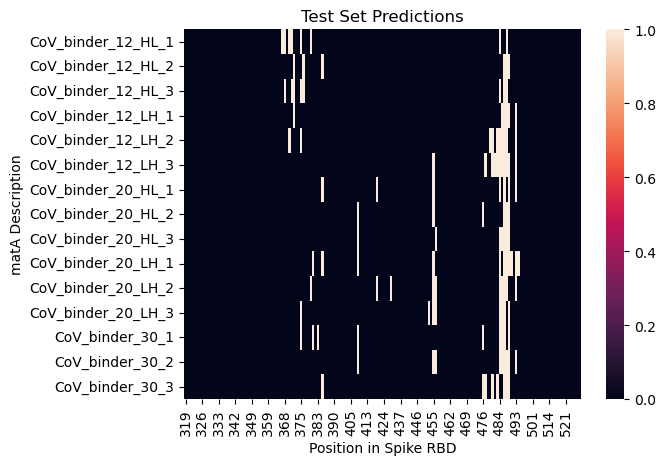

In [ ]:
# Test set predictions
## Note: CoV_binder_12 does not show any binding in PDB structures below position 446, meaning the predictions (which are consistent across replicates)
## around 359 to 383 are independent predictions. It would be interesting to understand why these appear. Is it a false positive prediction? Lack of data?
## Artifact of the assay or missed by crystalography?
Yh_test = unet.predict(x = X_test)
Yh_test = Yh_test.reshape((Yh_test.shape[0], Yh_test.shape[1])) > 0
Yh_test_df = pd.DataFrame(Yh_test)
Yh_test_df.columns = padded_pos_array.tolist()
Yh_test_df["mata_name"] = index_test
Yh_test_df = Yh_test_df.set_index(["mata_name"])

test_plot = sns.heatmap(data = Yh_test_df)
test_plot.set(xlabel = "Position in Spike RBD", ylabel = "matA Description", title = "Test Set Predictions")
test_plot

1/1 [==============================] - 0s 49ms/step


<Axes: title={'center': 'Validation Set Predictions'}, xlabel='Position in Spike RBD', ylabel='matA Description'>

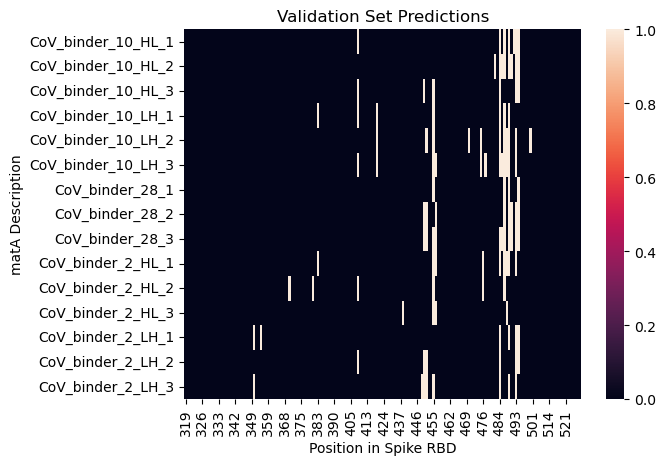

In [ ]:
# Validation set predictions
Yh_val = unet.predict(x = X_val)
Yh_val = Yh_val.reshape((Yh_val.shape[0], Yh_val.shape[1])) > 0
Yh_val_df = pd.DataFrame(Yh_val)
Yh_val_df.columns = padded_pos_array.tolist()
Yh_val_df["mata_name"] = index_val
Yh_val_df = Yh_val_df.set_index(["mata_name"])

val_plot = sns.heatmap(data = Yh_val_df)
val_plot.set(xlabel = "Position in Spike RBD", ylabel = "matA Description", title = "Validation Set Predictions")
val_plot

## Performance Assessment
While I would like to spend some more time on comparing the different algorithms, I feel that this gives a reasonable overview of the performance improvement from using the modeling approach. Below I compute the Jaccard indices for the validation set given the predictions from the model above or from the manuscript. The model reached an average value of 0.149 compared to the algorithm in the manuscript reaching 0.115. This shows nearly a 30% increase in agreement with the PDB structures. 

A few comments on the results, the algorithm from the manuscript is more specific with the PDB data while the modeling approach is more sensitive. Meaning that if there is a binding site, it's more likely that it would be picked up by the modeling approach. Yet the certainty that when you find a binding site given the manuscript algorithm, it has a higher chance of agreeing with the PDB data. 

In [15]:
# Check for Jaccard Index to measure performance based on sites identified
Yh_jaccard = []

for i, mata_name in enumerate(index_val):
    Yh_pos = padded_pos_array[Yh_val[i,:]]
    Y_pos = np.array(Y_val)[i, :] == 1
    Y_pos = Y_pos.reshape(-1)
    Y_pos = padded_pos_array[Y_pos]
    y_int = len([x for x in Yh_pos if x in Y_pos])
    y_union = len(list(set(Yh_pos.tolist() + Y_pos.tolist())))
    Yh_jaccard.append(y_int / y_union)

print(f"Jaccard Index for the Validation Set: Mean = {np.mean(Yh_jaccard)}")

Jaccard Index for the Validation Set: Mean = 0.14926321166760767


In [16]:
# Check manuscript for same validation datasets
manu_epi_data = pd.read_csv("manuscript_data/supp_tbl_8-epitope_comparison_filtered_results.csv")
manu_epi_data = pd.merge(manu_epi_data, pdbids, left_on = "Name", right_on = "Antibody")
manu_epi_data = manu_epi_data[manu_epi_data["Short_Name"].isin(val_list)]
manu_epi_data = manu_epi_data.drop(["Name", "Antibody", "PDB_id", "Primary_Chains", "Secondary_Chains"], axis = 1)
manu_epi_data = manu_epi_data.melt(id_vars = ["Short_Name"], var_name = "pos", value_name = "score")
manu_epi_data["score"] = manu_epi_data["score"].notna()
manu_epi_data = manu_epi_data[manu_epi_data["score"]]
manu_epi_data = manu_epi_data[["Short_Name", "pos"]]
manu_epi_data["pos"] = manu_epi_data["pos"].astype(str)

Ah_jaccard = []

for i, short_name in enumerate(val_list):
    Ah_pos = manu_epi_data["pos"][manu_epi_data["Short_Name"] == short_name].astype(str)
    Y_pos = pdb_resid["residnum"][pdb_resid["Short_Name"] == short_name].astype(str)
    y_int = len([x for x in Ah_pos.tolist() if x in Y_pos.tolist()])
    y_union = len(list(set(Ah_pos.tolist() + Y_pos.tolist())))
    Ah_jaccard.append(y_int / y_union)

print(f"Jaccard Index for the manscript algorithm for Validation Set: Mean = {np.mean(Ah_jaccard)}")

Jaccard Index for the manscript algorithm for Validation Set: Mean = 0.11507936507936507


# Discovery Data Set
Below is the remainder or the discovery data set predictions. These were Cov_binder data that I could not find PDB associated information for. A few I may have just missed and taking some more time to slewth around may allow me to add some more samples to the training / test / validation splits.

To note, there appear to be highly redundant binding regions, three to be specific. 1) Around 368-385, 2) another around 450-455, and a strong binding site 3) around 480-493. These also likely correspond to specific regions of the RBD which lead to neutralization of the receptor binding, indicating a bias in the data deposited into the PDB and a bias that may come through in the modeling. This risk is discussed above, but I think additional invesigations will find corroborating information supporting these binding domains. 

3/3 [==============================] - 0s 48ms/step


<Axes: title={'center': 'Discovery Set Predictions'}, xlabel='Position in Spike RBD', ylabel='matA Description'>

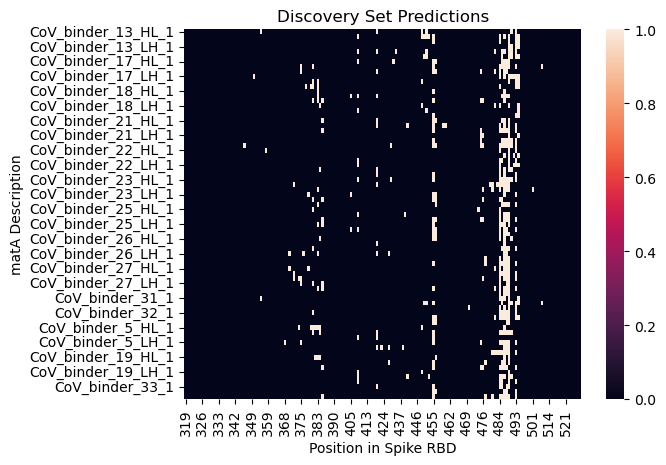

In [23]:
Yh_discov = unet.predict(x = X_discov)
Yh_discov = Yh_discov.reshape((Yh_discov.shape[0], Yh_discov.shape[1])) > 0
Yh_discov_df = pd.DataFrame(Yh_discov)
Yh_discov_df.columns = padded_pos_array.tolist()
Yh_discov_df["mata_name"] = index_discov
Yh_discov_df = Yh_discov_df.set_index(["mata_name"])

discov_plot = sns.heatmap(data = Yh_discov_df)
discov_plot.set(xlabel = "Position in Spike RBD", ylabel = "matA Description", title = "Discovery Set Predictions")
discov_plot

## Predictions Output
Below I write out the predictions to a csv file to be used in followup analyses.

In [43]:
def generate_output_preds(X_set, index_set, label):
    """
    Generate a dataframe for output of predictions and binding locations.

    Arguments:
        X_set: X_(train/test/val/discov) set generated above, used for prediction with unet model.
        index_set: index_(train/test/val/discov) set generated above, used for labeling mata names.
        label: string to be given as the dataset name.

    Returns:
        Pandas DataFrame with predictions per location across the RBD.
    """
    preds = unet.predict(x = X_set)
    preds = preds.reshape((preds.shape[0], preds.shape[1]))
    preds = pd.DataFrame(preds)
    preds.columns = padded_pos_array.tolist()
    preds["mata_name"] = index_set
    preds = preds.melt(id_vars = "mata_name", var_name = "RBD_position", value_name = "pred_score")
    preds["pred_binding"] = preds["pred_score"] > 0
    preds = preds.sort_values(by = ["mata_name", "RBD_position"], ignore_index = True)
    preds["dataset"] = label
    preds = preds[["dataset", "mata_name", "RBD_position", "pred_score", "pred_binding"]]
    return preds

# Train data
training_preds = generate_output_preds(X_train, index_train, "train")
testing_preds = generate_output_preds(X_test, index_test, "test")
valid_preds = generate_output_preds(X_val, index_val, "valid")
discov_preds = generate_output_preds(X_discov, index_discov, "discov")

all_preds = pd.concat([training_preds, testing_preds, valid_preds, discov_preds], ignore_index = True)
all_preds.to_csv("./additional_data/epitope_discovery_predictions.csv", index = False)

3/3 [==============================] - 0s 47ms/step
